#개, 고양이 분류 V3
- 부분 데이터: 훈련 개, 고양이 각각 1000개, 테스트 각각 500개
- 데이터 부풀리기 적용

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-01-14 07:51:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  16.0MB/s    in 5.7s    

2023-01-14 07:51:41 (11.5 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

- 모델 구성

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
model = Sequential([ 
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [8]:
model_path = 'best_model.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

- 데이터 부풀리기

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,          # randomly rotate image in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.5,            # 도형의 기울기
    zoom_range=[0.8, 1.2],      # 0.8~1.2배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # 뒤집지 않음
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 1000 images belonging to 2 classes.


In [12]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    steps_per_epoch=100,
    validation_steps=50,
    callbacks=[mc, es]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.5750
Epoch 1: val_loss improved from inf to 0.63881, saving model to best_model.h5
100/100 [==============================] - 27s 185ms/step - loss: 0.7301 - accuracy: 0.5750 - val_loss: 0.6388 - val_accuracy: 0.6310
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.6425
Epoch 2: val_loss did not improve from 0.63881
100/100 [==============================] - 19s 185ms/step - loss: 0.6423 - accuracy: 0.6425 - val_loss: 0.7134 - val_accuracy: 0.6090
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.6775
Epoch 3: val_loss did not improve from 0.63881
100/100 [==============================] - 20s 195ms/step - loss: 0.6051 - accuracy: 0.6775 - val_loss: 0.6579 - val_accuracy: 0.6460
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.6920
Epoch 4: val_loss improved from 0.6388

In [13]:
best_model = load_model(model_path)
best_model.evaluate(test_generator)

50/50 [==============================] - 3s 61ms/step - loss: 0.4205 - accuracy: 0.8130


[0.42051056027412415, 0.8130000233650208]

- 시각화

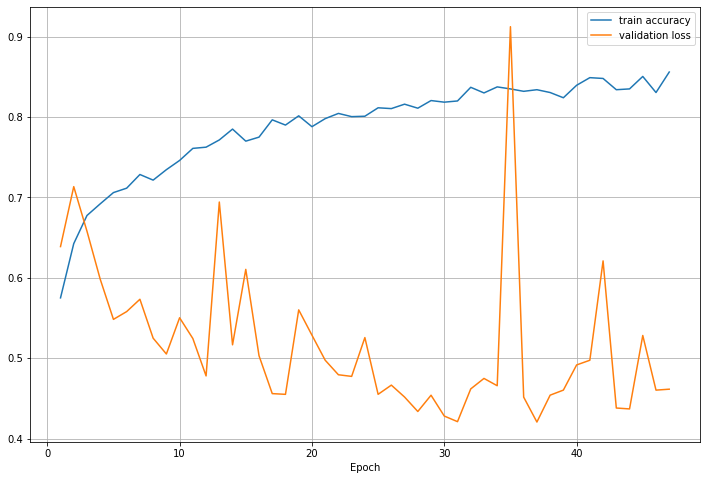

In [14]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.show()